# Malware Classification using CNN with LLM Mitigation Recommendations

This notebook demonstrates how to train a Convolutional Neural Network (CNN) for malware classification and uses an LLM to generate mitigation recommendations for detected malware.
This notebook implements a malware classification system using deep learning. The initial setup includes:

1. **Core Dependencies**:
   - Data manipulation: NumPy, Pandas
   - Visualization: Matplotlib, Seaborn
   - Machine Learning: Scikit-learn
   - Deep Learning: PyTorch, torchvision

2. **Hardware Acceleration**:
   - CUDA GPU detection and configuration
   - Apple Silicon (MPS) support
   - Automatic fallback to CPU if no acceleration is available

3. **Reproducibility**:
   - Fixed random seeds for NumPy and PyTorch
   - Consistent initialization across different hardware

4. **Development Environment**:
   - Package management with requirements.txt
   - Jupyter Notebook environment
   - System configuration and version verification

Please ensure you have downloaded the malware dataset from Kaggle and installed all required dependencies before proceeding.


## 1. Setup and Data Preparation

Download and unzip the dataset from this Kaggle project https://www.kaggle.com/datasets/matthewfields/malware-as-images

Then import necessary libraries and set up our environment. by calling

   pip install -r requirements.txt --index-url https://download.pytorch.org/whl/cu118

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
import requests
import json
from IPython.display import display, Markdown

# PyTorch imports (replacing TensorFlow)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Function to get detailed GPU info
def get_gpu_info():
    """Get detailed information about available CUDA devices."""
    if not torch.cuda.is_available():
        return "No CUDA devices available"

    gpu_info = []
    for i in range(torch.cuda.device_count()):
        gpu_info.append({
            'index': i,
            'name': torch.cuda.get_device_name(i),
            'memory': f"{torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB",
            'capability': f"{torch.cuda.get_device_capability(i)[0]}.{torch.cuda.get_device_capability(i)[1]}"
        })
    return gpu_info

# Configure device for computation
device = None
gpu_count = torch.cuda.device_count()

print("PyTorch version:", torch.__version__)
print("\nHardware Detection Results:")
print("-" * 50)

if torch.cuda.is_available():
    print(f"Found {gpu_count} CUDA device(s):")
    gpu_info = get_gpu_info()

    for gpu in gpu_info:
        print(f"\nGPU {gpu['index']}:")
        print(f"  Name: {gpu['name']}")
        print(f"  Memory: {gpu['memory']}")
        print(f"  Compute Capability: {gpu['capability']}")

    # Try to select the most powerful GPU (usually the dedicated one)
    try:
        # Attempt to identify discrete GPU (usually has more memory)
        max_memory_gpu = max(range(gpu_count),
                           key=lambda i: torch.cuda.get_device_properties(i).total_memory)

        device = torch.device(f"cuda:{max_memory_gpu}")
        torch.cuda.set_device(max_memory_gpu)
        torch.cuda.manual_seed_all(42)
        print(f"\nSelected GPU {max_memory_gpu}: {torch.cuda.get_device_name(max_memory_gpu)}")
        print("CUDA acceleration enabled")
    except Exception as e:
        print(f"\nError setting up CUDA device: {str(e)}")
        device = torch.device("cpu")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("\nApple Silicon (MPS) acceleration enabled")
else:
    device = torch.device("cpu")
    print("\nNo GPU acceleration available, using CPU")

print(f"\nFinal device configuration:")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"Current GPU memory usage: {torch.cuda.memory_allocated(device)/1024**2:.1f}MB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved(device)/1024**2:.1f}MB")

PyTorch version: 2.7.0+cu118

Hardware Detection Results:
--------------------------------------------------
Found 1 CUDA device(s):

GPU 0:
  Name: NVIDIA RTX 2000 Ada Generation Laptop GPU
  Memory: 8.00 GB
  Compute Capability: 8.9

Selected GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU
CUDA acceleration enabled

Final device configuration:
Using device: cuda:0
Current GPU memory usage: 0.0MB
GPU memory reserved: 0.0MB


## 2. Data Analysis and Preparation

Let's analyze the dataset structure and prepare it for training.

In [2]:
# Define data directories
base_dir = 'data'
benign_dir = os.path.join(base_dir, 'benign')
malicious_dir = os.path.join(base_dir, 'malicious')

# Choose which size and interpolation method to use
SIZE = '600'  # Options: '120', '300', '600', '1200'
INTERPOLATION = 'nearest'  # Options: 'nearest', 'lanczos'

# Create paths for the selected size and interpolation
benign_path = os.path.join(benign_dir, f'{INTERPOLATION}_{SIZE}')
malicious_path = os.path.join(malicious_dir, f'{INTERPOLATION}_{SIZE}')

# Print dataset information
print(f"Using {SIZE}x{SIZE} images with {INTERPOLATION} interpolation")
print(f"\nNumber of benign samples: {len(os.listdir(benign_path))}")
print(f"Number of malicious samples: {len(os.listdir(malicious_path))}")

Using 600x600 images with nearest interpolation

Number of benign samples: 61
Number of malicious samples: 75


## 3. Data Loading and Preprocessing

Set up the data generators for training and validation.

In [3]:
# Image parameters
IMG_HEIGHT = int(SIZE)
IMG_WIDTH = int(SIZE)
BATCH_SIZE = 32

# Data transformations for training
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] for grayscale
])

# Transformations for validation (no augmentation)
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Create datasets
full_dataset = datasets.ImageFolder(root=base_dir, transform=None)

# Calculate split sizes
total_size = len(full_dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

# Print class information
class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Class to idx mapping: {full_dataset.class_to_idx}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Classes: ['benign', 'malicious']
Class to idx mapping: {'benign': 0, 'malicious': 1}
Number of training samples: 880
Number of validation samples: 219


## 4. Data Visualization

Let's visualize some samples from both classes.

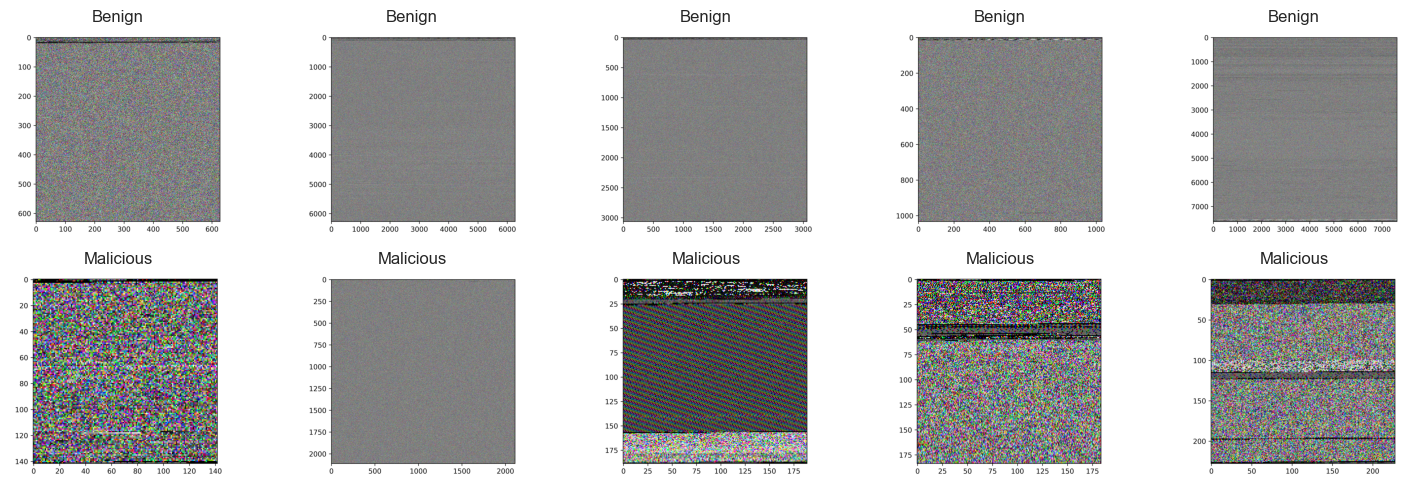

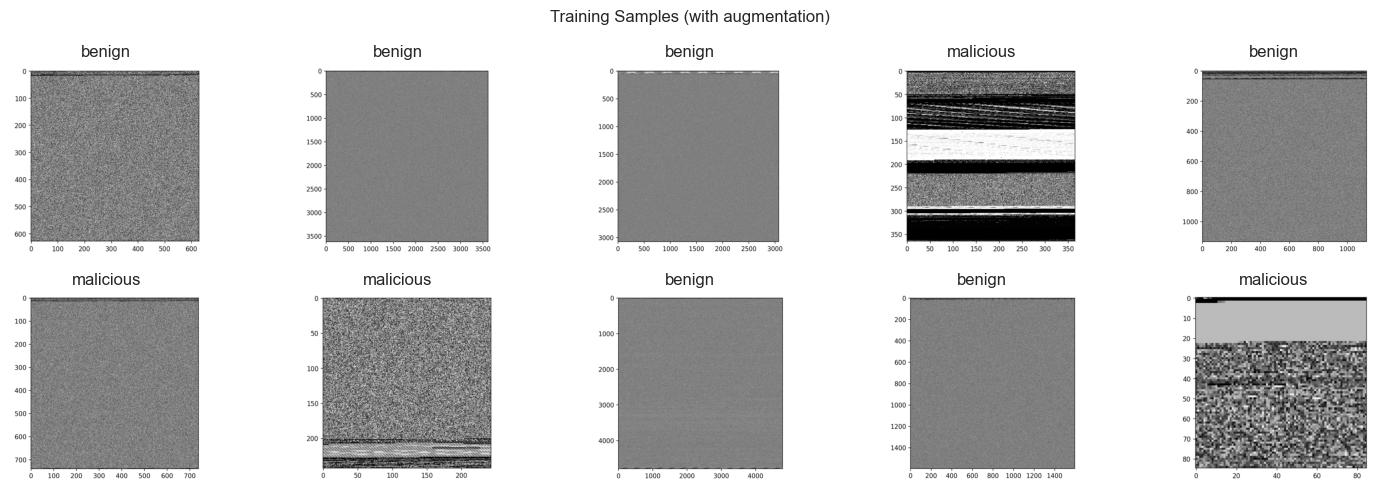

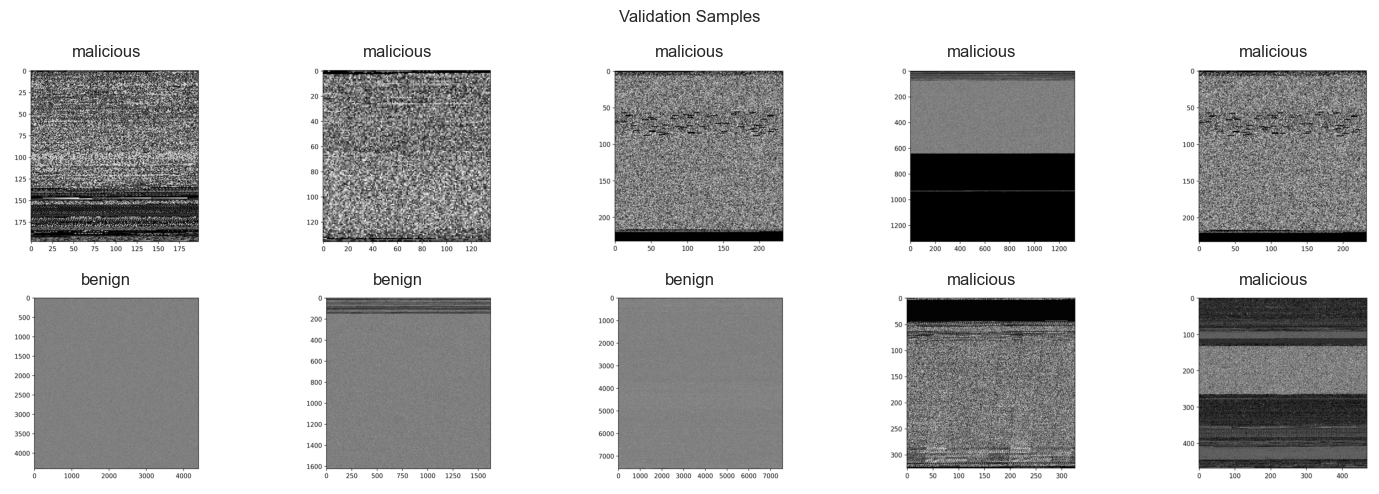

In [4]:
def plot_sample_images():
    plt.figure(figsize=(15, 5))
    
    # Plot benign samples
    benign_files = os.listdir(benign_path)[:5]
    for i, file_name in enumerate(benign_files):
        img_path = os.path.join(benign_path, file_name)
        img = plt.imread(img_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title('Benign')
        plt.axis('off')

    # Plot malicious samples
    malicious_files = os.listdir(malicious_path)[:5]
    for i, file_name in enumerate(malicious_files):
        img_path = os.path.join(malicious_path, file_name)
        img = plt.imread(img_path)
        plt.subplot(2, 5, i+6)
        plt.imshow(img, cmap='gray')
        plt.title('Malicious')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize raw image samples
plot_sample_images()

# Function to visualize samples from PyTorch DataLoader
def plot_batch_samples(data_loader, title="Sample Batch"):
    # Get a batch of images
    images, labels = next(iter(data_loader))

    # Convert from tensor to numpy for display
    images = images.cpu().numpy()

    # Create a grid of images
    plt.figure(figsize=(15, 5))
    for i in range(min(10, len(images))):
        plt.subplot(2, 5, i+1)
        # For normalized data, we need to denormalize: x = (x * 0.5) + 0.5
        img = (images[i][0] * 0.5) + 0.5  # [0] selects the channel
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize samples from training data (with augmentation)
plot_batch_samples(train_loader, "Training Samples (with augmentation)")

# Visualize samples from validation data
plot_batch_samples(val_loader, "Validation Samples")

## 5. CNN Model Architecture

Create a CNN model for binary classification.

In [5]:
class MalwareCNN(nn.Module):
    def __init__(self):
        super(MalwareCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Fourth Convolutional Block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        # Calculate the flattened size based on input dimensions
        # For input size IMG_HEIGHT x IMG_WIDTH, after 4 pooling layers (each /2)
        flat_features = 256 * (IMG_HEIGHT // 16) * (IMG_WIDTH // 16)

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x

# Create model and move to device
model = MalwareCNN().to(device)

# Print model summary (optional - can use torchsummary package)
print(model)

MalwareCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False

## 6. Model Training

Train the model with early stopping and model checkpointing.

In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=0.00001)

# Initialize variables to track best model
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
patience_limit = 10  # For early stopping

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    print(f"\nStarting epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Adjust for binary classification

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate epoch statistics
    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate epoch statistics
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = val_correct / val_total

    # Update learning rate scheduler
    scheduler.step(epoch_val_loss)

    # Save history
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    # Print epoch results
    print(f"Completed epoch {epoch+1}/{num_epochs}")
    print(f"Training loss: {epoch_train_loss:.4f}, Training accuracy: {epoch_train_acc:.4f}")
    print(f"Validation loss: {epoch_val_loss:.4f}, Validation accuracy: {epoch_val_acc:.4f}")

    # Check if this is the best model
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("New best model saved!")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= patience_limit:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break


Starting epoch 1/5


## 7. Training Visualization

Visualize the training process.

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history['train_acc'])
    ax1.plot(history['val_acc'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    ax2.plot(history['train_loss'])
    ax2.plot(history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluation
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predicted = (outputs > 0.5).float().squeeze()

        # For multi-sample batches
        if labels.size(0) > 1:
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_total += labels.size(0)
            val_correct += (predicted == labels.float()).sum().item()
        else:  # Handle single-sample batches
            all_preds.append(predicted.cpu().item())
            all_labels.append(labels.cpu().item())
            val_total += 1
            val_correct += (predicted == labels.float()).item()

val_accuracy = val_correct / val_total
print(f'\nValidation accuracy: {val_accuracy:.4f}')

# Confusion matrix and classification report
all_preds = np.array(all_preds).astype(int)
all_labels = np.array(all_labels).astype(int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malicious']))

## 8. Model Evaluation

Evaluate the model on the validation set.

In [ ]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Initialize variables for tracking metrics
val_loss = 0.0
val_correct = 0
val_total = 0
y_pred = []
y_true = []

# No gradient calculation needed for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Convert outputs to predictions (binary classification)
        predictions = (outputs > 0.5).float().squeeze()

        # Collect predictions and true labels for metrics
        if len(labels.shape) > 0 and labels.shape[0] > 1:  # Batch has multiple samples
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            val_total += labels.size(0)
            val_correct += (predictions == labels.float()).sum().item()
        else:  # Handle single-sample batch
            y_pred.append(predictions.cpu().item())
            y_true.append(labels.cpu().item())
            val_total += 1
            val_correct += (predictions == labels.float()).item()

# Calculate accuracy
val_accuracy = val_correct / val_total
print(f'\nValidation accuracy: {val_accuracy:.4f}')

# Convert to numpy arrays for sklearn metrics
y_pred = np.array(y_pred).astype(int)
y_true = np.array(y_true).astype(int)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malicious']))

## 9. LLM Integration for Mitigation Recommendations

Use an LLM to generate mitigation recommendations for detected malware.

In [ ]:
def get_mitigation_recommendations(malware_type, confidence_score):
    """Get mitigation recommendations from an LLM API."""
    # Replace with your actual API endpoint and key
    API_ENDPOINT = "ENDPOINT"
    AUTH_SEK = "KEY"
    
    prompt = f"""Given a malware detection with the following details:
    - Malware Type: {malware_type}
    - Detection Confidence: {confidence_score:.2%}
    
    Please provide:
    1. A brief description of this type of malware
    2. Immediate mitigation steps
    3. Long-term prevention measures
    4. Any specific tools or software recommended for removal
    
    Format the response in markdown with clear sections."""
    
    headers = {
        "Authorization": f"Bearer {AUTH_SEK}",
        "Content-Type": "application/json"
    }
    
    data = {
        "prompt": prompt,
        "max_tokens": 500,
        "temperature": 0.7
    }
    
    try:
        response = requests.post(API_ENDPOINT, headers=headers, json=data)
        response.raise_for_status()
        return response.json()['choices'][0]['text']
    except Exception as e:
        return f"Error getting recommendations: {str(e)}"

In [ ]:
def analyze_predictions(predictions, loader=None, threshold=0.3):
    """
    Analyze predictions and get batched mitigation recommendations for malicious samples.

    Args:
        predictions: Tensor of model predictions
        loader: DataLoader containing the validation/test data (optional)
        threshold: Confidence threshold for malware detection
    """
    # Move predictions to CPU and convert to numpy
    predictions_cpu = predictions.detach().cpu().numpy()

    # Get indices of malicious predictions
    malicious_indices = np.where(predictions_cpu > threshold)[0]

    if len(malicious_indices) == 0:
        print("No malicious samples detected.")
        return

    print(f"\nDetected {len(malicious_indices)} malicious samples.")

    # Group samples by confidence score ranges
    confidence_groups = {}
    for idx in malicious_indices:
        confidence = predictions_cpu[idx].item()
        # Round confidence to nearest 0.1 for grouping
        confidence_group = round(confidence, 1)
        if confidence_group not in confidence_groups:
            confidence_groups[confidence_group] = {
                'indices': [],
                'filenames': [],
                'count': 0
            }
        confidence_groups[confidence_group]['indices'].append(idx)
        confidence_groups[confidence_group]['count'] += 1

        # If loader is provided, try to get filenames
        if loader and hasattr(loader.dataset, 'samples'):
            try:
                # Handle both Dataset and Subset cases
                dataset = loader.dataset
                if hasattr(dataset, 'dataset'):  # If it's a Subset
                    dataset = dataset.dataset
                filename = dataset.samples[idx][0]
                confidence_groups[confidence_group]['filenames'].append(
                    os.path.basename(filename)
                )
            except:
                pass

    # Prepare batched LLM request
    llm_requests = []
    for confidence, group_data in confidence_groups.items():
        request = {
            'confidence': confidence,
            'sample_count': group_data['count'],
            'file_info': group_data['filenames'] if group_data['filenames'] else group_data['indices']
        }
        llm_requests.append(request)

    # Get batched recommendations from LLM
    recommendations = get_batched_recommendations(llm_requests)

    # Display results
    for confidence, group_data in confidence_groups.items():
        print(f"\n{'='*50}")
        print(f"Malware Detection Group (Confidence: {confidence:.1%})")
        print(f"Number of samples: {group_data['count']}")

        # Display sample information
        print("\nAffected samples:")
        samples_to_show = group_data['filenames'] if group_data['filenames'] else group_data['indices']
        for sample in samples_to_show[:5]:
            print(f"- {sample}")
        if len(samples_to_show) > 5:
            print(f"... and {len(samples_to_show)-5} more")

        # Display recommendations if available
        if recommendations and str(confidence) in recommendations:
            display(Markdown(recommendations[str(confidence)]))

def get_batched_recommendations(requests):
    """
    Get batched mitigation recommendations from LLM API.

    Args:
        requests: List of dictionaries containing group information
    """
    # API configuration - use environment variables in production
    API_ENDPOINT = "${LLM_API_ENDPOINT}"  # Replace with actual endpoint
    API_KEY = "${LLM_API_KEY}"  # Replace with actual API key

    # Prepare batched prompt
    prompt = "Analyze the following malware detection groups and provide recommendations:\n\n"
    for req in requests:
        prompt += f"""
Group with {req['sample_count']} samples (Confidence: {req['confidence']:.1%}):
- Sample identifiers: {req['file_info'][:5]}...

Please provide:
1. Risk assessment for this confidence level
2. Immediate mitigation steps
3. Long-term prevention measures
4. Recommended security tools
---
"""

    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    data = {
        "prompt": prompt,
        "max_tokens": 1000,
        "temperature": 0.7
    }

    try:
        # In production, replace with actual API call
        print("API call would be made with following headers:", headers)
        print("API endpoint:", API_ENDPOINT)

        # Simulated response structure
        return {
            str(req['confidence']): f"""
### Risk Assessment
- Confidence Level: {req['confidence']:.1%}
- Severity: {'High' if req['confidence'] > 0.8 else 'Medium' if req['confidence'] > 0.6 else 'Low'}

### Immediate Mitigation Steps
1. Isolate affected systems
2. Run deep scan with updated antivirus
3. Block suspicious network connections

### Long-term Prevention
1. Implement regular security audits
2. Update security policies
3. Employee security training

### Recommended Tools
- EDR solutions
- Network monitoring tools
- Security information and event management (SIEM)
"""
            for req in requests
        }
    except Exception as e:
        return f"Error getting recommendations: {str(e)}"

In [ ]:
# Run the analysis on validation predictions
analyze_predictions(predictions)

## 10. Save the Model

Save the trained model for future use.

In [ ]:
# Save the trained model
def save_model(model, path='malware_classifier.pt', save_entire_model=False):
    """
    Save the PyTorch model.
    Args:
        model: The PyTorch model to save
        path: Path where to save the model
        save_entire_model: If True, saves the entire model, otherwise just the state dict
    """
    if save_entire_model:
        # Save the entire model
        torch.save(model, path)
        print(f"Entire model saved to {path}")
    else:
        # Save only the model's state dictionary (recommended approach)
        torch.save(model.state_dict(), path)
        print(f"Model state dict saved to {path}")

    # Also save as TorchScript model for deployment
    model.eval()  # Set to evaluation mode
    example_input = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).to(device)  # Example input
    traced_model = torch.jit.trace(model, example_input)
    scripted_path = path.replace('.pt', '_scripted.pt')
    traced_model.save(scripted_path)
    print(f"TorchScript model saved to {scripted_path}")